# Hurricane Matthew Keyword Collection Analysis

In [1]:
import json, sys, datetime
import pandas as pd; import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load all of the tweets into a single dataframe
# df = pd.read_json('/data/chime/matthew/keyword_tweets.json')

In [3]:
# x = df.head(10000)
# len(df)

In [4]:
# For simplicity, let's do what you should never do and iterate over the dataframe and create a jsonl file:
# length = len(df)
# with open('/data/chime/matthew/keyword_tweets.jsonl','w') as oFile:
#     for index, row in df.iterrows():
#         oFile.write(row.to_json()+"\n")
#         if index%100==0:
#             sys.stderr.write("\r{0:2.2f} % ".format(index/length*100))

First, Identify tweets that inclue the following location based terms:

    Brunswick
    Savanah
    Charleston
    Tybee (Island)

This is actually best done with `grep`. Run the following code block in the directory

```bash
grep -i "brunswick"  keyword_tweets.jsonl > locations/brunswick.jsonl && 
grep -i "savannah"   keyword_tweets.jsonl > locations/savannah.jsonl && 
grep -i "charleston" keyword_tweets.jsonl > locations/charleston.jsonl && 
grep -i "tybee"      keyword_tweets.jsonl > locations/tybee.jsonl
```

In [312]:
#Basic analysis for each of these subfiles

In [2]:
def read_place(place):
    tweets = []
    with open("/data/chime/matthew/locations/"+place+".jsonl") as inFile:
        for line in inFile:
            obj = json.loads(line)
            tweets.append(obj)
    df = pd.DataFrame(tweets)
    df['datetime'] = df.created_at.apply(lambda x: pd.Timestamp(x*1000000))
    df['hour'] = df.datetime.apply(lambda t: datetime.datetime(t.year, t.month, t.day, t.hour))
    gb_hour = df.groupby('hour')
    agged = gb_hour.agg({'user_screen_name':{
                          'Unique Users': pd.Series.nunique,
                          'Tweet Count' : pd.Series.count
                        },
                     'tweet_type': {
                        'posts'  : lambda x: sum(x=='post'),
                        'rewteets' : lambda x: sum(x=='share'),
                        }
                    })
    return df, agged

In [3]:
def summary_stats(df):
    return "{0} tweets from {1} unique users".format(len(df), pd.Series.nunique(df.user_screen_name))

In [4]:
places = [
    {'name':'savannah'},
    {'name': 'brunswick'},
    {'name': 'tybee'},
    {'name': 'charleston'}
]

In [5]:
for p in places:
    p['df'], p['agged'] = read_place(p['name'])

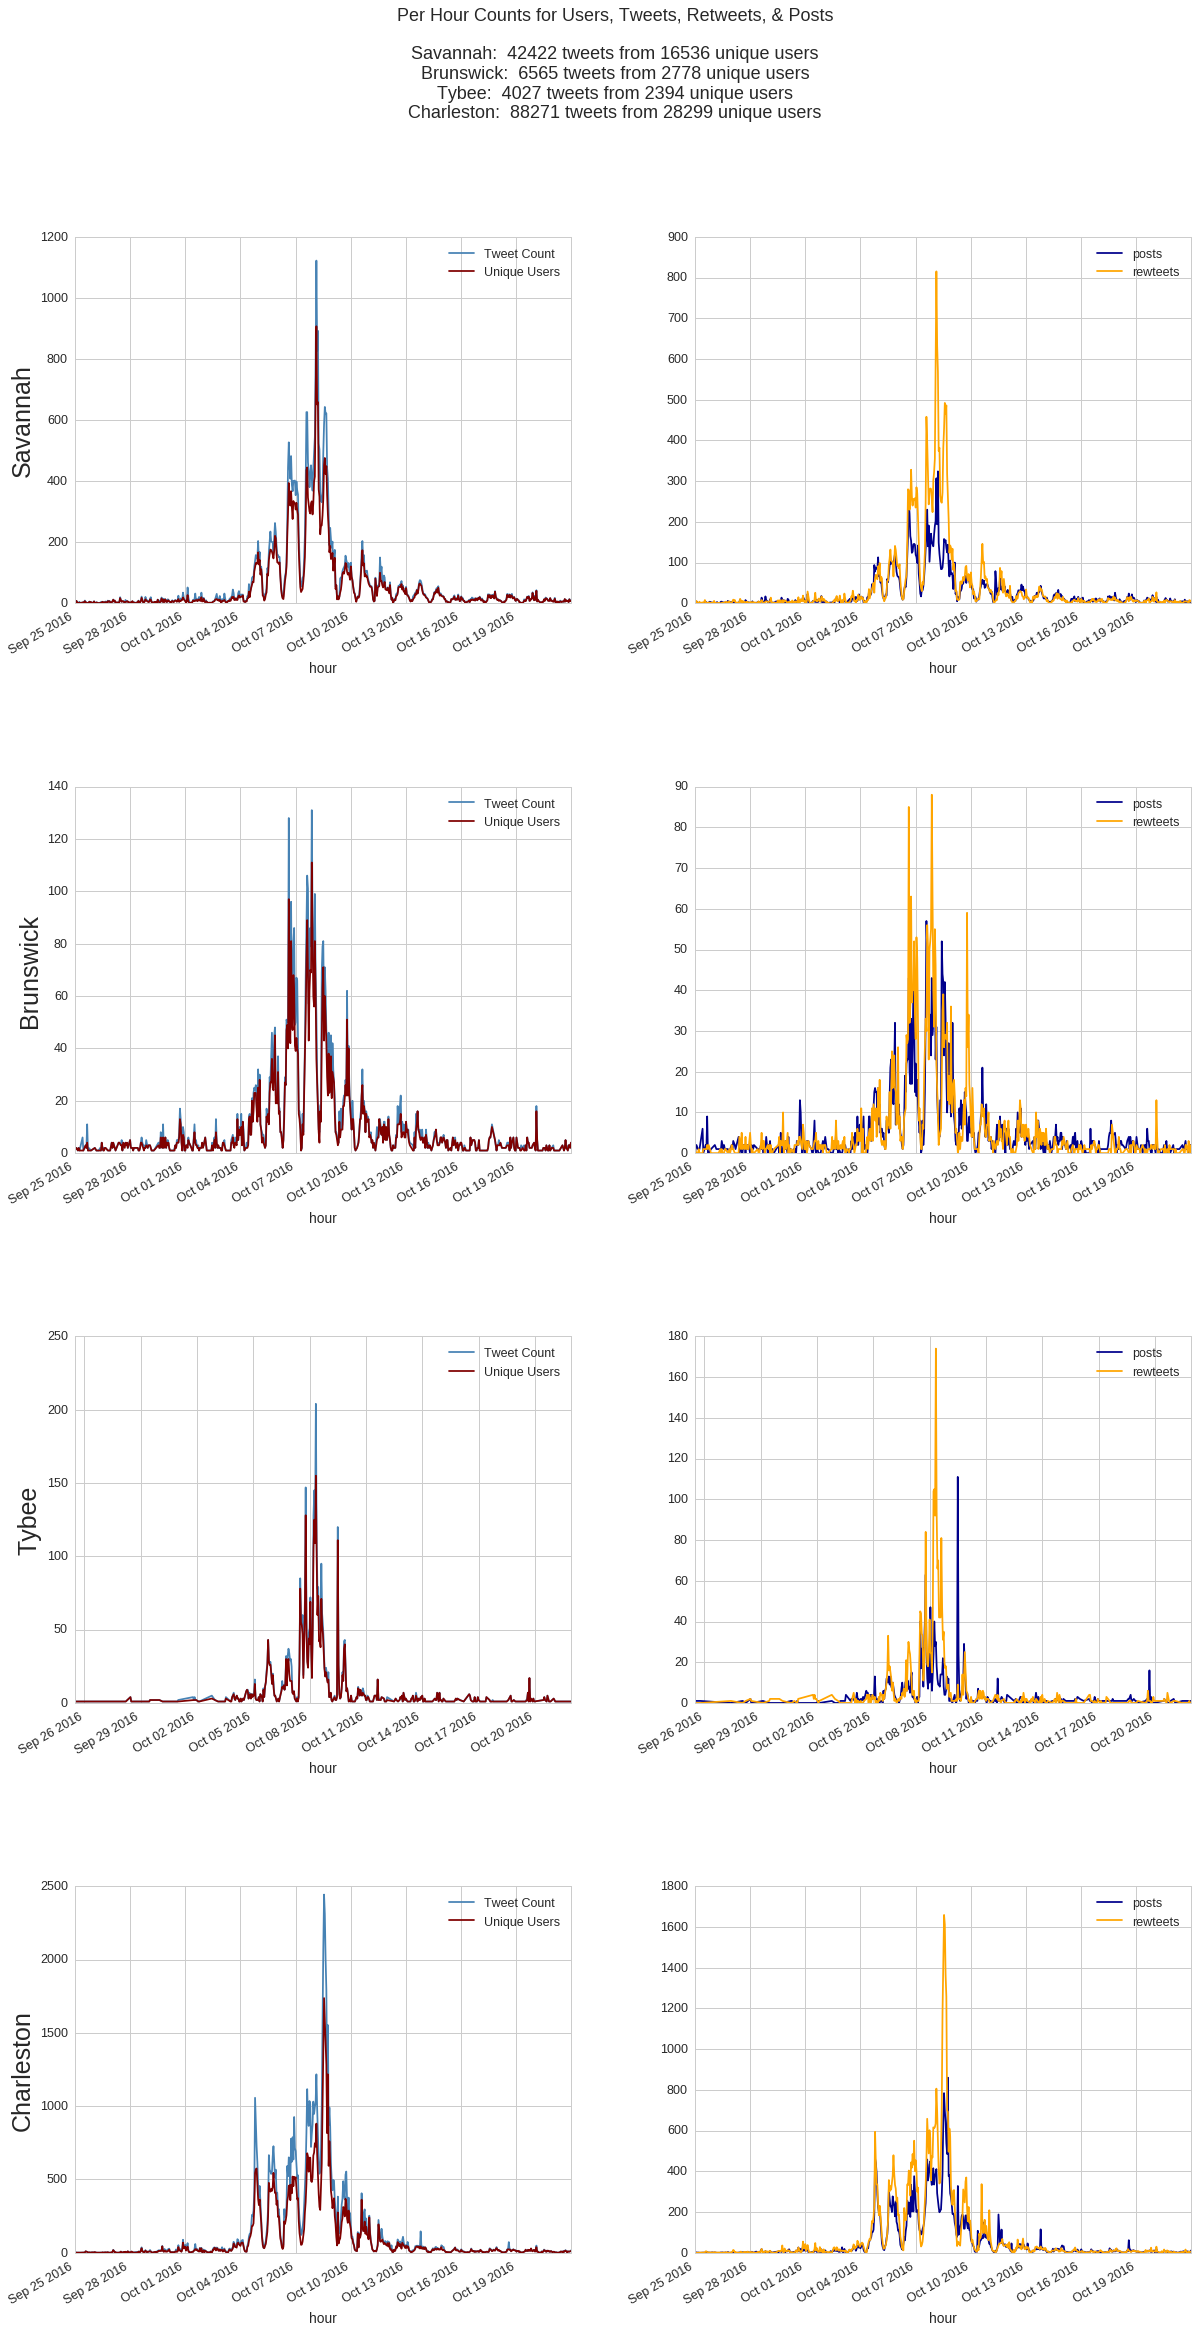

In [6]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20,40), facecolor='w', edgecolor='k')
plt.subplots_adjust(wspace=0.25, hspace=0.5)

axes = axs.ravel()

for idx, p in enumerate(places):
    ax = axes[idx*2]

    p['agged']['user_screen_name'].plot(ax=ax, color=['steelblue','maroon'] )

    ax.set_ylabel(p['name'].capitalize(), fontsize=25)
 
    ax2 = axes[idx*2+1]
    p['agged']['tweet_type'].plot(ax=ax2, color=['darkblue','orange'])
    
plt.suptitle("Per Hour Counts for Users, Tweets, Retweets, & Posts\n\n{0}".format(
        "\n".join([p['name'].capitalize() + ":  " + summary_stats(p['df']) for p in places])
        ),fontsize=18)

## Export CSVs

In [8]:
for p in places:
    to_export = p['df'][['datetime','user_name','user_screen_name','text','user_location','tweet_type']].sort_values(by='datetime')
    print(p['name'], len(to_export))
#     with open('/data/chime/matthew/locations/'+p['name']+'.csv','w') as oFile: 
#         to_export.to_csv(oFile, index=False)

savannah 42422
brunswick 6565
tybee 4027
charleston 88271


# Cleaning up the Brunswick Tweets

In [71]:
x = places[1]['df']
len(x)

6565

In [72]:
x = x.fillna(value="")

In [73]:
x.user_location.value_counts().head(10)

Brunswick, GA                 822
                              606
New Brunswick, Canada         348
New Brunswick, New Jersey     311
New Brunswick, NJ             277
North Brunswick, NJ           199
Brunswick, Ga                 153
Atlanta, GA                   149
Fredericton, New Brunswick    111
Saint John, New Brunswick     100
Name: user_location, dtype: int64

In [135]:
y = x[~x.user_location.str.contains(r'(maine|canada|can|nj|jersey|virginia|.*New Brunswick|New|Nouveau.\s*Brunswick|NC|OH|NY|MA|ME|DC|CO|MD|WA|CA|CO|FL|NV|TX)',case=False)]

-c:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [136]:
len(y)

3079

In [137]:
y.user_location.value_counts()

Brunswick, GA                     822
                                  606
Brunswick, Ga                     153
Atlanta, GA                       149
Brunswick, Georgia                 96
United States                      76
Atlanta                            43
Savannah & Brunswick, GA           42
Georgia, USA                       39
Brunswick Georgia                  35
Savannah, GA                       31
Brunswick, GA                      29
Brunswick                          27
Georgia                            24
Brunswick,GA & Atlanta,GA          20
USA                                20
Earth                              16
Brunswick,Ga                       15
Brunswick/Jesup, Ga                14
Southeast GA, USA                  12
Augusta, GA                        11
Atlanta, Georgia                   11
Athens, GA                         11
Tornado Alley                      11
ÜT: 34.092992,-77.897074           10
Brunswick,  Georgia                10
Brunswick GA

In [145]:
z = x[x.user_location.str.contains(r'brunswick.*(ga|georgia)',case=False)]

-c:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


In [147]:
len(z)

1381

In [148]:
to_export = z[['datetime','user_name','user_screen_name','text','user_location','tweet_type']].sort_values(by='datetime')
with open('/data/www/chime/just_brunswick.csv','w') as oFile: 
    to_export.to_csv(oFile, index=False)